In [2]:
from pyspark.sql import SparkSession

In [3]:
review = '/user/asyabani/yelp/yelp_academic_dataset_review.json'
business = '/user/asyabani/yelp/yelp_academic_dataset_business.json'
tip = '/user/asyabani/yelp/yelp_academic_dataset_tip.json'
user = '/user/asyabani/yelp/yelp_academic_dataset_user.json'
checkin = '/user/asyabani/yelp/yelp_academic_dataset_checkin.json'

In [4]:
spark = SparkSession.builder.getOrCreate()

In [5]:
#spark.conf.set("spark.sql.broadcastTimeout", 4800)

In [6]:
dfr = spark.read.json(review)
dfb = spark.read.json(business)
dft = spark.read.json(tip)
dfu = spark.read.json(user)
dfc = spark.read.json(checkin)

### Unnest column 'attributes' and 'hours'
Dataframe `dfb_a` and `dfb_h`

In [7]:
from pyspark.sql.functions import col
def flatten_df(nested_df):
    stack = [((), nested_df)]
    columns = []

    while len(stack) > 0:
        parents, df = stack.pop()

        flat_cols = [
            col(".".join(parents + (c[0],))).alias("_".join(parents + (c[0],)))
            for c in df.dtypes
            if c[1][:6] != "struct"
        ]

        nested_cols = [
            c[0]
            for c in df.dtypes
            if c[1][:6] == "struct"
        ]

        columns.extend(flat_cols)

        for nested_col in nested_cols:
            projected_df = df.select(nested_col + ".*")
            stack.append((parents + (nested_col,), projected_df))

    return nested_df.select(columns)

In [8]:
# Unnest 'attributes' columns
dfb_a = flatten_df(dfb.select("attributes"))

In [9]:
# Unnest 'hours' columns
dfb_h = flatten_df(dfb.select("hours"))

### Unnest 'attributes_Ambience' by creating new columns
Dataframe `dfb_aa`

In [10]:
dfb_aa = dfb_a.select('attributes_Ambience')

In [11]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
dfb_aa = dfb_aa.withColumn('Ambience_touristy', when(dfb_aa.attributes_Ambience.contains('\'touristy\': True'),1).otherwise(0))\
            .withColumn('Ambience_hipster', when(dfb_aa.attributes_Ambience.contains('\'hipster\': True'),1).otherwise(0))\
            .withColumn('Ambience_romantic', when(dfb_aa.attributes_Ambience.contains('\'romantic\': True'),1).otherwise(0))\
            .withColumn('Ambience_divey', when(dfb_aa.attributes_Ambience.contains('\'divey\': True'),1).otherwise(0))\
            .withColumn('Ambience_intimate', when(dfb_aa.attributes_Ambience.contains('\'intimate\': True'),1).otherwise(0))\
            .withColumn('Ambience_trendy', when(dfb_aa.attributes_Ambience.contains('\'trendy\': True'),1).otherwise(0))\
            .withColumn('Ambience_upscale', when(dfb_aa.attributes_Ambience.contains('\'upscale\': True'),1).otherwise(0))\
            .withColumn('Ambience_classy', when(dfb_aa.attributes_Ambience.contains('\'classy\': True'),1).otherwise(0))\
            .withColumn('Ambience_casual', when(dfb_aa.attributes_Ambience.contains('\'casual\': True'),1).otherwise(0))

### Merging all new dataframes with the original one
Dataframe `dfb_new`

In [12]:
from pyspark.sql.functions import monotonically_increasing_id
dfb_idx   = dfb.withColumn("row_id", monotonically_increasing_id())
dfb_a_idx = dfb_a.withColumn("row_id", monotonically_increasing_id())
dfb_h_idx = dfb_h.withColumn("row_id", monotonically_increasing_id())
dfb_aa_idx = dfb_aa.withColumn("row_id", monotonically_increasing_id())

In [13]:
merged1 = dfb_idx.join(dfb_a_idx, ("row_id"))
merged2 = merged1.join(dfb_h_idx, ("row_id"))
merged3 = merged2.join(dfb_aa_idx, ("row_id"))
dfb_new = merged3.drop("row_id","drop_Ambience")

### Variable Selections and Merging

In [14]:
dfrreg = dfr.withColumnRenamed('cool','cool_review')\
            .withColumnRenamed('funny','funny_review')\
            .withColumnRenamed('useful','useful_review')\
            .withColumnRenamed('stars','stars_review')\
            .withColumnRenamed('user_id','user_id_r')\
            .withColumnRenamed('business_id','business_id_r')

In [15]:
dfbreg = dfb_new.withColumnRenamed('review_count','rev_count_biz')\
                .withColumnRenamed('stars','stars_biz')

In [16]:
dfureg = dfu.withColumnRenamed('cool','cool_user')\
            .withColumnRenamed('funny','funny_user')\
            .withColumnRenamed('useful','useful_user')\
            .withColumnRenamed('average_stars','avg_stars_user')\
            .withColumnRenamed('review_count','rev_count_user')

In [17]:
dfregjoin = dfrreg.join(dfbreg, dfrreg.business_id_r == dfbreg.business_id)\
        .drop('address','city','hours','is_open','latitude','longitude','name','postal_code','state','attributes',
             'hours_Monday','hours_Saturday','hours_Sunday','hours_Thursday','hours_Friday','hours_Tuesday','hours_Wednesday','attributes_Ambience')

In [18]:
dfreg = dfregjoin.join(dfureg, dfregjoin.user_id_r == dfureg.user_id)\
        .drop('name')

### Data Cleaning

#### Change 'elite' and 'friends' into integer counts

In [19]:
dfreg = dfreg.withColumn('elite', regexp_replace('elite', '20,20', '2020'))

In [20]:
dfreg = dfreg.withColumn('elite_count', size(split(col('elite'), r",")))\
            .withColumn('friends_count', size(split(col('friends'), r",")))

#### Add 'yelp_since_year' from 'yelping_since'

In [21]:
dfreg = dfreg.withColumn("yelping_since",to_timestamp("yelping_since"))

In [22]:
dfreg = dfreg.withColumn("yelp_since_year", year("yelping_since"))

#### Add 'year_posted' for review

In [23]:
dfreg = dfreg.withColumn("year_posted", year(to_timestamp("date")))

#### Add 'years_gap', difference between 'year_posted' and 'yelp_since_year'

In [24]:
dfreg = dfreg.withColumn("years_gap", dfreg.year_posted-dfreg.yelp_since_year)

#### Additional Columns: Count Non-Null Attributes

In [25]:
dfreg = dfreg.withColumn('count_AcceptsInsurance', 
                         when(dfreg.attributes_AcceptsInsurance.isin(['True','False']),1).otherwise(0))

In [26]:
dfreg = dfreg.withColumn('count_AgesAllowed', 
                         when(dfreg.attributes_AgesAllowed.contains('\''),1).otherwise(0))

In [27]:
dfreg = dfreg.withColumn('count_Alcohol', 
                         when(dfreg.attributes_Alcohol.contains('\''),1).otherwise(0))

In [28]:
dfreg = dfreg.withColumn('count_BYOB', 
                         when(dfreg.attributes_BYOB.isin(['True','False']),1).otherwise(0))

In [29]:
dfreg = dfreg.withColumn('count_BYOBCorkage', 
                         when(dfreg.attributes_BYOBCorkage.contains('\''),1).otherwise(0))

In [30]:
dfreg = dfreg.withColumn('count_BestNights', 
                         when(dfreg.attributes_BestNights.contains('\''),1).otherwise(0))

In [31]:
dfreg = dfreg.withColumn('count_BikeParking', 
                         when(dfreg.attributes_BikeParking.isin(['True','False']),1).otherwise(0))

In [32]:
from pyspark.sql.functions import col
c='count_BusinessAcceptsBitcoin'
a='attributes_BusinessAcceptsBitcoin'

dfreg = dfreg.withColumn(c, 
                         when(col(a).isin(['True','False']),1).otherwise(0))

In [33]:
from pyspark.sql.functions import col
c='count_BusinessAcceptsCreditCards'
a='attributes_BusinessAcceptsCreditCards'

dfreg = dfreg.withColumn(c, 
                         when(col(a).isin(['True','False']),1).otherwise(0))

In [34]:
from pyspark.sql.functions import col
c='count_BusinessParking'
a='attributes_BusinessParking'

dfreg = dfreg.withColumn(c, 
                         when(col(a).contains('\''),1).otherwise(0))

In [35]:
from pyspark.sql.functions import col
c='count_ByAppointmentOnly'
a='attributes_ByAppointmentOnly'

dfreg = dfreg.withColumn(c, 
                         when(col(a).isin(['True','False']),1).otherwise(0))

In [36]:
from pyspark.sql.functions import col
c='count_Caters'
a='attributes_Caters'

dfreg = dfreg.withColumn(c, 
                         when(col(a).isin(['True','False']),1).otherwise(0))

In [37]:
from pyspark.sql.functions import col
c='count_CoatCheck'
a='attributes_CoatCheck'

dfreg = dfreg.withColumn(c, 
                         when(col(a).isin(['True','False']),1).otherwise(0))

In [38]:
from pyspark.sql.functions import col
c='count_Corkage'
a='attributes_Corkage'

dfreg = dfreg.withColumn(c, 
                         when(col(a).isin(['True','False']),1).otherwise(0))

In [39]:
from pyspark.sql.functions import col
c='count_DietaryRestrictions'
a='attributes_DietaryRestrictions'

dfreg = dfreg.withColumn(c, 
                         when(col(a).contains('\''),1).otherwise(0))

In [40]:
from pyspark.sql.functions import col
c='count_DogsAllowed'
a='attributes_DogsAllowed'

dfreg = dfreg.withColumn(c, 
                         when(col(a).isin(['True','False']),1).otherwise(0))

In [41]:
from pyspark.sql.functions import col
c='count_DriveThru'
a='attributes_DriveThru'

dfreg = dfreg.withColumn(c, 
                         when(col(a).isin(['True','False']),1).otherwise(0))

In [42]:
from pyspark.sql.functions import col
c='count_GoodForDancing'
a='attributes_GoodForDancing'

dfreg = dfreg.withColumn(c, 
                         when(col(a).isin(['True','False']),1).otherwise(0))

In [43]:
from pyspark.sql.functions import col
c='count_GoodForKids'
a='attributes_GoodForKids'

dfreg = dfreg.withColumn(c, 
                         when(col(a).isin(['True','False']),1).otherwise(0))

In [44]:
from pyspark.sql.functions import col
c='count_GoodForMeal'
a='attributes_GoodForMeal'

dfreg = dfreg.withColumn(c, 
                         when(col(a).contains('\''),1).otherwise(0))

In [45]:
from pyspark.sql.functions import col
c='count_HairSpecializesIn'
a='attributes_HairSpecializesIn'

dfreg = dfreg.withColumn(c, 
                         when(col(a).contains('\''),1).otherwise(0))

In [46]:
from pyspark.sql.functions import col
c='count_HappyHour'
a='attributes_HappyHour'

dfreg = dfreg.withColumn(c, 
                         when(col(a).isin(['True','False']),1).otherwise(0))

In [47]:
from pyspark.sql.functions import col
c='count_HasTV'
a='attributes_HasTV'

dfreg = dfreg.withColumn(c, 
                         when(col(a).isin(['True','False']),1).otherwise(0))

In [48]:
from pyspark.sql.functions import col
c='count_Music'
a='attributes_Music'

dfreg = dfreg.withColumn(c, 
                         when(col(a).contains('\''),1).otherwise(0))

In [49]:
from pyspark.sql.functions import col
c='count_NoiseLevel'
a='attributes_NoiseLevel'

dfreg = dfreg.withColumn(c, 
                         when(col(a).contains('\''),1).otherwise(0))

In [50]:
from pyspark.sql.functions import col
c='count_Open24Hours'
a='attributes_Open24Hours'

dfreg = dfreg.withColumn(c, 
                         when(col(a).isin(['True','False']),1).otherwise(0))

In [51]:
from pyspark.sql.functions import col
c='count_OutdoorSeating'
a='attributes_OutdoorSeating'

dfreg = dfreg.withColumn(c, 
                         when(col(a).isin(['True','False']),1).otherwise(0))

In [52]:
from pyspark.sql.functions import col
c='count_RestaurantsAttire'
a='attributes_RestaurantsAttire'

dfreg = dfreg.withColumn(c, 
                         when(col(a).contains('\''),1).otherwise(0))

In [53]:
from pyspark.sql.functions import col
c='count_RestaurantsCounterService'
a='attributes_RestaurantsCounterService'

dfreg = dfreg.withColumn(c, 
                         when(col(a).isin(['True','False']),1).otherwise(0))

In [54]:
from pyspark.sql.functions import col
c='count_RestaurantsDelivery'
a='attributes_RestaurantsDelivery'

dfreg = dfreg.withColumn(c, 
                         when(col(a).isin(['True','False']),1).otherwise(0))

In [55]:
from pyspark.sql.functions import col
c='count_RestaurantsGoodForGroups'
a='attributes_RestaurantsGoodForGroups'

dfreg = dfreg.withColumn(c, 
                         when(col(a).isin(['True','False']),1).otherwise(0))

In [56]:
from pyspark.sql.functions import col
c='count_RestaurantsPriceRange2'
a='attributes_RestaurantsPriceRange2'

dfreg = dfreg.withColumn(c, 
                         when(col(a).isin(['1','2','3','4']),1).otherwise(0))

In [57]:
from pyspark.sql.functions import col
c='count_RestaurantsReservations'
a='attributes_RestaurantsReservations'

dfreg = dfreg.withColumn(c, 
                         when(col(a).isin(['True','False']),1).otherwise(0))

In [58]:
from pyspark.sql.functions import col
c='count_RestaurantsTableService'
a='attributes_RestaurantsTableService'

dfreg = dfreg.withColumn(c, 
                         when(col(a).isin(['True','False']),1).otherwise(0))

In [59]:
from pyspark.sql.functions import col
c='count_RestaurantsTakeOut'
a='attributes_RestaurantsTakeOut'

dfreg = dfreg.withColumn(c, 
                         when(col(a).isin(['True','False']),1).otherwise(0))

In [60]:
from pyspark.sql.functions import col
c='count_Smoking'
a='attributes_Smoking'

dfreg = dfreg.withColumn(c, 
                         when(col(a).contains('\''),1).otherwise(0))

In [61]:
from pyspark.sql.functions import col
c='count_WheelchairAccessible'
a='attributes_WheelchairAccessible'

dfreg = dfreg.withColumn(c, 
                         when(col(a).isin(['True','False']),1).otherwise(0))

In [62]:
from pyspark.sql.functions import col
c='count_WiFi'
a='attributes_WiFi'

dfreg = dfreg.withColumn(c, 
                         when(col(a).contains('\''),1).otherwise(0))

In [63]:
from pyspark.sql.functions import sum
count_columns = [column for column in dfreg.columns if column.startswith("count")]

In [64]:
from functools import reduce
from operator import add
def column_add(a,b):
     return  a._add_(b)
dfreg = dfreg.withColumn('count_sum', 
         reduce(add, (col(x) for x in count_columns)))

#### Add 'text_length' from review text

In [65]:
dfreg = dfreg.withColumn('text_length',length(dfreg.text))

#### Add 'compliment_sum' for total compliments of users

In [66]:
compl_columns = [column for column in dfreg.columns if column.startswith("compliment")]
from functools import reduce
from operator import add
def column_add(a,b):
     return  a._add_(b)
dfreg = dfreg.withColumn('compliment_sum', 
         reduce(add, (col(x) for x in compl_columns)))

In [67]:
dfclas = dfreg.withColumn('stars_rev_class', when(dfreg.stars_review>=4,1)\
                          .otherwise(0))
dfclas = dfclas.withColumn('stars_biz_class', when(dfreg.stars_biz>3,1)\
                          .otherwise(0))

In [68]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer, StringIndexer, CountVectorizer, IDF, StopWordsRemover, Word2Vec

In [69]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="clean_words")
word2Vec = Word2Vec(vectorSize=300, inputCol=remover.getOutputCol(), outputCol="tokens")

pipe = Pipeline(stages=[tokenizer, remover, word2Vec])

In [70]:
sample_size = 0.008

In [71]:
%time pipe_fit = pipe.fit(dfclas.where(dfclas.categories.contains('Restaurants')).where(dfclas.years_gap>=0).sample(sample_size))


CPU times: user 69.1 ms, sys: 21.9 ms, total: 91.1 ms
Wall time: 4min 3s


In [72]:
dfclas.where(dfclas.categories.contains('Restaurants')).where(dfclas.years_gap>=0).count()

5574628

In [73]:
dfclas.sample(sample_size).count()

68870

In [74]:
dfclas.where(dfclas.categories.contains('Restaurants')).where(dfclas.years_gap>=0).sample(sample_size).count()

44884

In [75]:
%time encodedData = pipe_fit.transform(dfclas.where(dfclas.categories.contains('Restaurants')).where(dfclas.years_gap>=0).sample(sample_size))


CPU times: user 32.3 ms, sys: 9.38 ms, total: 41.6 ms
Wall time: 1.65 s


In [76]:
class_features = ['funny_review', 'cool_review', 'stars_review', 'rev_count_biz', 'stars_biz', 'count_sum',
                  'elite_count', 'friends_count', 'years_gap', 'funny_user', 'useful_user', 'cool_user', 
                  'compliment_sum', 'fans',  'text_length', 'tokens']


In [77]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=class_features, outputCol="class_features")
dfclasb = assembler.transform(encodedData)

### Random Forest Classifier

In [78]:
dfclasbrs = dfclasb

In [79]:
dfclasbrs = dfclasbrs.withColumn("useful_review_binary", \
   when((dfclasbrs['useful_review'] < 1), 0) \
     .otherwise (1))

In [79]:
dfclasbrs.count()

45053

In [80]:
%%time
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Load and parse the data file, converting it to a DataFrame.
data = dfclasbrs

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="useful_review_binary", featuresCol="class_features", numTrees=10)

# Train model.  This also runs the indexers.
model = rf.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

CPU times: user 35.1 ms, sys: 18.9 ms, total: 54 ms
Wall time: 1min 59s


In [81]:
from pyspark.mllib.evaluation import MulticlassMetrics

predictions_eval = predictions.withColumn("prediction", predictions["prediction"].cast(DoubleType()))
predictions_eval = predictions.withColumn("useful_review_binary", predictions["useful_review_binary"].cast(DoubleType()))

results = predictions_eval.select(['prediction', 'useful_review_binary'])
predictionAndLabels=results.rdd
metrics = MulticlassMetrics(predictionAndLabels)

cm=metrics.confusionMatrix().toArray()
accuracy=(cm[0][0]+cm[1][1])/cm.sum()
precision=(cm[0][0])/(cm[0][0]+cm[1][0])
recall=(cm[0][0])/(cm[0][0]+cm[0][1])
f1=(2*precision*recall)/(precision+recall)

print("RandomForestClassifier: accuracy:",accuracy)
print("RandomForestClassifier: precision:",precision)
print("RandomForestClassifier: recall:",recall)
print("RandomForestClassifier: f1-score:",f1)

RandomForestClassifier: accuracy: 0.7385766126046064
RandomForestClassifier: precision: 0.734147582697201
RandomForestClassifier: recall: 0.8870987578403641
RandomForestClassifier: f1-score: 0.8034083314769437


In [82]:
import pandas as pd

featureImp = pd.DataFrame(list(zip(model.featureImportances, \
assembler.getInputCols())),columns=["Importance","features"]) \
.sort_values(by="Importance",ascending=False)

featureImp.head(15)

,Importance,features
1,0.197206,cool_review
0,0.196397,funny_review
10,0.107994,useful_user
9,0.078958,funny_user
13,0.075619,fans
7,0.027416,friends_count
14,0.027337,text_length
12,0.024076,compliment_sum
11,0.023134,cool_user
6,0.004283,elite_count


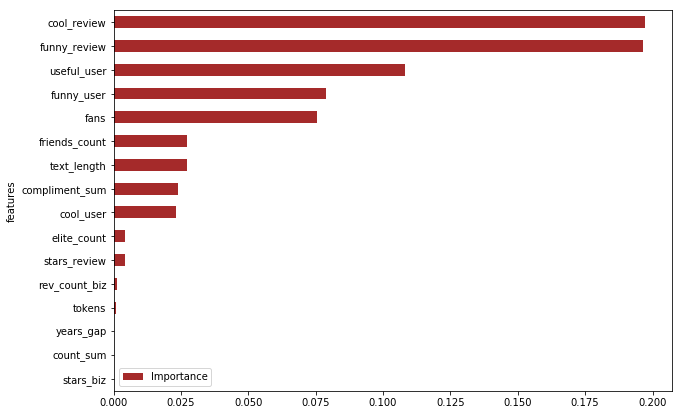

In [84]:
import matplotlib.pyplot as plt
featureImp.set_index('features').sort_values('Importance', ascending=True).plot(kind='barh', figsize=(10,7), color='brown')
plt.show()

### Logistic Regression Classifier

In [80]:
%%time
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Load and parse the data file, converting it to a DataFrame.
data = dfclasbrs

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train a RandomForest model.
lr = LogisticRegression(labelCol="useful_review_binary", featuresCol="class_features")

# Train model.  This also runs the indexers.
model_lr = lr.fit(trainingData)

# Make predictions.
predictions_lr = model_lr.transform(testData)

CPU times: user 44.3 ms, sys: 18.9 ms, total: 63.2 ms
Wall time: 3min 5s


In [81]:
from pyspark.mllib.evaluation import MulticlassMetrics

predictions_eval = predictions_lr.withColumn("prediction", predictions_lr["prediction"].cast(DoubleType()))
predictions_eval = predictions_lr.withColumn("useful_review_binary", predictions_lr["useful_review_binary"].cast(DoubleType()))

results = predictions_eval.select(['prediction', 'useful_review_binary'])
predictionAndLabels=results.rdd
metrics = MulticlassMetrics(predictionAndLabels)

cm=metrics.confusionMatrix().toArray()
accuracy=(cm[0][0]+cm[1][1])/cm.sum()
precision=(cm[0][0])/(cm[0][0]+cm[1][0])
recall=(cm[0][0])/(cm[0][0]+cm[0][1])
f1=(2*precision*recall)/(precision+recall)
print("LogisticRegression: accuracy:",accuracy)
print("LogisticRegression: precision:",precision)
print("LogisticRegression: recall:",recall)
print("LogisticRegression: f1-score:",f1)

LogisticRegression: accuracy: 0.7652154263332329
LogisticRegression: precision: 0.7511360033815915
LogisticRegression: recall: 0.9031766200762389
LogisticRegression: f1-score: 0.8201696186465124


Feature: 0, Score: 0.58973
Feature: 1, Score: 1.87486
Feature: 2, Score: -0.16181
Feature: 3, Score: -0.00017
Feature: 4, Score: 0.06598
Feature: 5, Score: -0.01000
Feature: 6, Score: 0.07627
Feature: 7, Score: 0.00043
Feature: 8, Score: 0.00900
Feature: 9, Score: -0.00001
Feature: 10, Score: 0.00001
Feature: 11, Score: -0.00002
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00004
Feature: 14, Score: 0.00073
Feature: 15, Score: 0.15689
Feature: 16, Score: 0.54609
Feature: 17, Score: 0.78869
Feature: 18, Score: 0.44177
Feature: 19, Score: -0.46971
Feature: 20, Score: -2.96548
Feature: 21, Score: -1.75020
Feature: 22, Score: 1.68405
Feature: 23, Score: -0.02378
Feature: 24, Score: 1.20261
Feature: 25, Score: -1.59334
Feature: 26, Score: -1.46677
Feature: 27, Score: 0.59382
Feature: 28, Score: 0.02922
Feature: 29, Score: 0.63891
Feature: 30, Score: -0.44430
Feature: 31, Score: 1.00180
Feature: 32, Score: -2.16809
Feature: 33, Score: 1.25907
Feature: 34, Score: 3.49067
Feature: 35, Scor

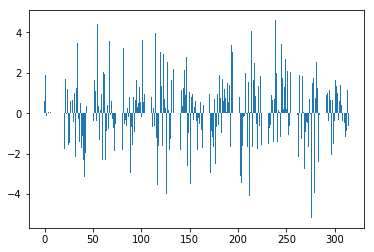

In [103]:
from matplotlib import pyplot
importance = model_lr.coefficients
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.limit(14).show()

Feature: 0, Score: 0.80354
Feature: 1, Score: 1.93057
Feature: 2, Score: -0.14551
Feature: 3, Score: -0.00020
Feature: 4, Score: -0.02285
Feature: 5, Score: 0.00222
Feature: 6, Score: 0.06634
Feature: 7, Score: 0.00035
Feature: 8, Score: 0.01319
Feature: 9, Score: -0.00010
Feature: 10, Score: 0.00002
Feature: 11, Score: 0.00003
Feature: 12, Score: -0.00008
Feature: 13, Score: 0.00045


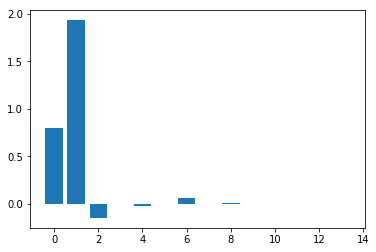

In [88]:
from matplotlib import pyplot
importance = model_lr.coefficients[0:14]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [82]:
model_lr.coefficients 

DenseVector([0.8035, 1.9306, -0.1455, -0.0002, -0.0229, 0.0022, 0.0663, 0.0003, 0.0132, -0.0001, 0.0, 0.0, -0.0001, 0.0004, 0.0007, -2.2107, -0.3192, -2.1378, 2.5213, 5.0193, -5.4546, -0.2187, 0.6958, -1.9137, -3.9405, 1.9898, -0.3535, -2.6643, 0.498, 1.5556, -0.2266, -1.5034, 1.5026, -0.7561, -0.0363, 1.0066, 0.4759, -2.222, 4.1473, 2.8347, -1.6757, -3.3514, -1.6777, -2.6299, -0.3295, 1.7791, 1.7845, -1.7613, -3.6843, -4.0663, -1.9075, 0.4173, 1.9821, 0.3608, -0.8176, -0.27, 2.0605, 0.1022, -3.6087, -4.0629, 0.0952, 2.264, 1.9154, -0.9766, -2.2799, 1.4921, 0.5883, 2.1597, 2.9345, 0.7246, 2.5055, -3.9865, -1.591, -0.0321, 4.4481, 1.0953, -0.9908, 1.38, 3.9729, 1.6181, 2.8701, 2.1301, 0.738, 1.7016, -0.0209, -2.0161, -2.4814, -1.2513, -0.0021, 2.4272, 1.2469, -3.5802, 0.8044, -2.5457, -0.8307, 3.1068, 0.1809, 3.9925, -0.5986, -3.4483, 2.504, 0.4724, -4.5424, -0.3717, -1.1573, -0.8036, -3.5092, 1.753, 1.1133, -0.759, -0.8558, -0.766, -0.3246, 0.4074, -1.1192, 0.9043, -3.4816, -2.4021, -3

### Gradient Boosted Tree Classifier

In [85]:
%%time
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Load and parse the data file, converting it to a DataFrame.
data = dfclasbrs

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train a model.
gb = GBTClassifier(labelCol="useful_review_binary", featuresCol="class_features")

# Train model.  This also runs the indexers.
model_gb = gb.fit(trainingData)

# Make predictions.
predictions_gb = model_gb.transform(testData)

CPU times: user 52.2 ms, sys: 18.1 ms, total: 70.3 ms
Wall time: 4min 9s


In [87]:
from pyspark.mllib.evaluation import MulticlassMetrics

predictions_eval = predictions_gb.withColumn("prediction", predictions_gb["prediction"].cast(DoubleType()))
predictions_eval = predictions_gb.withColumn("useful_review_binary", predictions_gb["useful_review_binary"].cast(DoubleType()))

results = predictions_eval.select(['prediction', 'useful_review_binary'])
predictionAndLabels=results.rdd
metrics = MulticlassMetrics(predictionAndLabels)

cm=metrics.confusionMatrix().toArray()
accuracy=(cm[0][0]+cm[1][1])/cm.sum()
precision=(cm[0][0])/(cm[0][0]+cm[1][0])
recall=(cm[0][0])/(cm[0][0]+cm[0][1])
f1=(2*precision*recall)/(precision+recall)
print("GradientBoostedTreeClassifier: accuracy:",accuracy)
print("GradientBoostedTreeClassifier: precision:",precision)
print("GradientBoostedTreeClassifier: recall:",recall)
print("GradientBoostedTreeClassifier: f1-score:",f1)

GradientBoostedTreeClassifier: accuracy: 0.762316715542522
GradientBoostedTreeClassifier: precision: 0.7566143374684378
GradientBoostedTreeClassifier: recall: 0.8705317670834912
GradientBoostedTreeClassifier: f1-score: 0.809585340068131


In [88]:
import pandas as pd

featureImp_gb = pd.DataFrame(list(zip(model_gb.featureImportances, \
assembler.getInputCols())),columns=["Importance","features"]) \
.sort_values(by="Importance",ascending=False)

featureImp_gb.head(15)

,Importance,features
1,0.134388,cool_review
10,0.116970,useful_user
14,0.052119,text_length
0,0.050211,funny_review
3,0.037173,rev_count_biz
9,0.017323,funny_user
11,0.016126,cool_user
13,0.012933,fans
12,0.007594,compliment_sum
4,0.005357,stars_biz


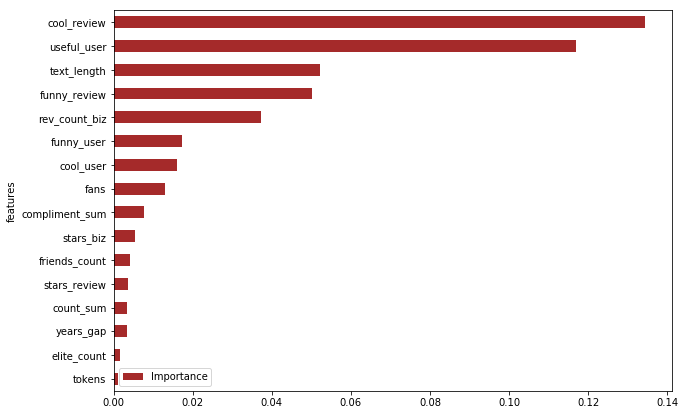

In [89]:
import matplotlib.pyplot as plt
featureImp_gb.set_index('features').sort_values('Importance', ascending=True).plot(kind='barh', figsize=(10,7), color='brown')
plt.show()

In [90]:
dfclasbrs.sample(0.2).count()

9033

In [91]:
dfclasbrs_pdf = dfclasbrs.sample(0.2).toPandas()

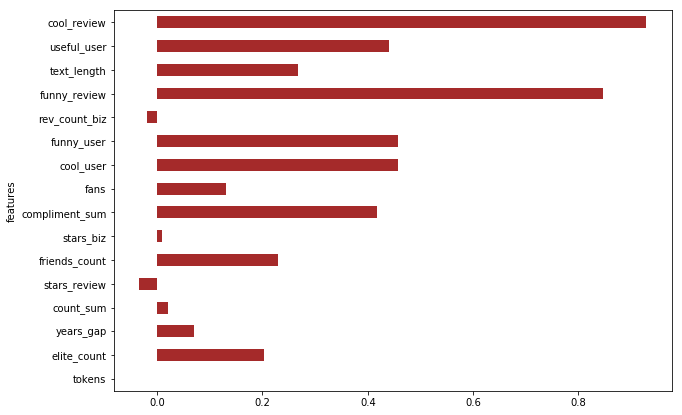

In [92]:
dfclasbrs_pdf.corr()['useful_review'].drop('useful_review')\
.reindex(index=featureImp_gb.sort_values("Importance", ascending=True)['features']).plot(kind='barh', figsize=(10,7), color='brown');
